# COVID-19 Disease Transimission

At the time of writing this, the world has been put to a standstill by COVID-19, an infectious disease caused by a recently discovered strain of coronavirus. It has managed to spread worldwide leading to hospitals filled to capacity with infected patients accompanied by an alarming amounts of deaths. As such, many people have taken up the task of modelling the transmission of the disease in order to forecast how many more infections might be expected as well as to learn as much as possible about the disease. In doing so, the hope is to provide data and insights in order to create informed policies that would effectively combat further spread of the disease.

This report aims to take a look at the process involved in forecasting along with an analysis on the transmission of the disease using the concepts and techniques learned from my classes on Linear Algebra (CS130) and Numerical Methods (CS131) both under Prof. JM Soriano. Along with that, this report as also been written in partial fulfillment of a requirement for my CS131 class. 

For this analysis, I will mainly be using data from the March 19, 2020 Kaggle daily report on COVID-19. 

And so without further ado, let us begin.

## Table of Contents
- [Our Tools](#tools)
    - [Matrix](#matrix)
    - [Gaussian Elimination](#gauss)
    - [Least Squares Curve Fitting](#lscf)
        - [Logistic Equation](#logistic)
        - [Guass-Newton Method for Least Squares Curve Fitting (LSCF)](#gaussnewton)

    
- [1. Analyzing the Covid19 Disease Transmission](#analysis)
    - [1.1 A Look at China](#china)
    - [1.2 Forecasting in Italy](#italy)
    - [1.3 Forecasting in the Philippines](#philippines)
        - [Making Assumptions](#assumptions)
    - [1.4 Other Pitfalls](#pitfalls)
        - [Determinism](#determinism)
        - [Result Manipulation](#manipulation)


- [Conclusion](#conclusion)

<a id="tools"></a>

## Our Tools

To help analyze and visualize the data, I will be using python 3.7.4 along with the following libraries:
* numpy 1.16.5
* pandas 0.25.1
* matplotlib 3.1.1

In [1]:
##### Setup #####

### Allow plots to display ###
%matplotlib inline

### Importing Necessary Libraries ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Formatting Settings ###
np.set_printoptions(suppress=True)

In addition to that, I will be using the following methods to perform some computational tasks:

<a id="matrix"></a>

### Matrix

A handy method that allows us to create a matrix which may be use for linear algebra. It may convert a string similar to SciLab notation into a 2d numpy array. It may also accept a 2d list. 

In [2]:
def matrix(vals):
    
    ### Convert from String ###
    if type(vals) == str:
        rows = vals.split(";")
        mat = [row.split() for row in rows]
        
    ### Convert from 2D List ###
    elif type(vals) == list:
        mat = [i for i in vals]
    
    ### Numpy List ###
    else:
        mat = vals.copy()
        
    assert [len(row) for row in mat] == [len(mat[0]) for row in mat], "Number of values in each row must match"
        
    ret = np.array(mat, dtype="float64")
    if  ret.shape == (1,1):
        return mat[0,0]
    
    return ret

<a id="gauss"></a>

### Gaussian Elimination

This method implements the Gaussian Elimination algorithm to solve for the unknowns of a system of linear equations. 

In other words, this method solves for $x$ given two matrices $A$ and $b$ such that $Ax = b$.

In [3]:
### Gaussian Elimination ####
def GE(A,b):
    aug = np.hstack([A,b])
    n, m = aug.shape

    ### Elimination Phase ###
    for i in range(n):

        ### Find Pivot Row ####
        max_row = i
        for p in range(i+1,n):
            if aug[p,i] > aug[max_row,i]:
                max_row = p

        ### Swap Rows ####
        temp = aug[i,:].copy()
        aug[i,:] = aug[max_row,:].copy()
        aug[max_row,:] = temp.copy()

        ### Make Leading Coefficient 1 ###
        aug[i, :] = aug[i,:] / aug[i,i]

        ### E2 Operations ###
        for j in range(i+1, n):
            aug[j,:] = aug[j, :] - aug[j,i] * aug[i,:]
        
    #### Backsubstitution Phase ###
    x = aug[:n, n:].copy()
    for i in range(n-1, -1, -1):
        for j in range(i+1,n):
            x[i,:] = x[i,:] - x[j,:]*aug[i, j]
        
    return x

Now a quick test to see if this works. Let's solve for $x$ when:

$$ 
A = \begin{bmatrix} 2 & -1 & 1 \\ 2 & 2 & -1 \\ 1 & 1 & -2 \end{bmatrix} \quad
b = \begin{bmatrix} 1 & 1 \\ 2 & 2 \\ 3 & 3 \end{bmatrix}
$$

In [4]:
A = matrix("2 -1 1; 1 2 -1; 1 1 -2")
b = matrix("1 1; 2 2; 3 3")
x = GE(A,b)
print(x)

[[ 1.  1.]
 [ 0.  0.]
 [-1. -1.]]


The method correctly gives us $$x = \begin{bmatrix} 1 & 1 \\ 0 & 0 \\ -1 & -1 \end{bmatrix}$$

To further verify, we can multiply $A$ and $x$ to see if it equals $b$ as follows:

In [5]:
b_verify = np.matmul(A, x)
print(b_verify)

[[1. 1.]
 [2. 2.]
 [3. 3.]]


As we can see, the result here matches our original values for b!

<a id="lscf"></a>
### Least Squares Curve Fitting

The following will implement the Least Squares Curve Fitting (LSCF) method. LSCF aims to find the parameters of a given function such that the total sum of squared residuals between the data points and the function are minimized.

<a id="logistic"></a>

#### The Logistic Equation

For this analysis, we will be fitting the following logistic equation:

$$P(t) = \frac{A}{1 + \text{exp}(-\frac{t - \mu}{\sigma})}$$

where the parameters $A$, $\mu$, $\frac{1}{\sigma}$ are the maximum
number of infected, time of half the maximum infection, and relative growth
(infection) rate respectively. Note that the function $\text{exp}$ is defined as $\text{exp}(x) = e^x$.

In other words, we will be modelling the disease transmission using a logistic growth curve. However, that raises the question: why would we model disease transmission using logistic growth? 

The reason for this is related to how a virus is transmitted. If there were no limit to how many people could be infected, then the rate of spread could be modelled with the following differential equation:

$$ \frac{dP}{dt} = rP $$

where $r$ is the relative growth rate and $P$ is the population already infected.

This would indicate that the rate of spread would be proportional to the current amount of people infected at a given point in time.

Solving the differential equation would give us the following:

$$P(t) = Ae^{rt}$$

where $A$ would be the initially infected population and $t$ as the number of days since the first infection. This is what is known as exponential growth.

Plotting this graph with $A = 1$ and $r = 1$ over the course of $30$ days, we get the following graph:

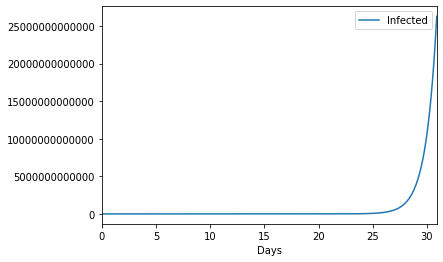

In [6]:
from math import exp

X = np.arange(0,310) / 10
Y = list(map(exp, X))

df = pd.DataFrame({"Days" : X, "Infected" : Y})

ax = df.plot(x = "Days", y = "Infected")
ax.ticklabel_format(style ='plain')
plt.show()

Notice how quickly the numbers grow. Over the course of $30$ days, this model would predict that the virus would spread to to $25$ *trillion* people. This would be an accurate model if the virus had unlimited access to people. However, there aren't that many people on earth, and this spread seems to be too fast otherwise the entirety of the planet earth would have already been infected. 

To help remedy that, we'll have to take two extra details into account. First, we only have a limited population that can get infected, a carrying capacity in other words. Second, it would be sensible to think that as the number of infections approaches this carrying capacity, the rate of spread would decrease as less and less people are capable of contracting the virus. 

This new rate of spread can be modelled by the following differential equation:

$$ \frac{dP}{dt} = (1 - \frac{P}{A}) r P $$

where $A$ is the maximum population or the carrying capacity, $P$ is the infected population, and $r$ is the relative growth rate. 

To help make sense of this equation, let's break it down. $\frac{P}{A}$ would give us the proportion of the infected poulation to the total population. The term $1 - \frac{P}{a}$ would give us the proportion of the remaining population to the total population. We limit the rate of spread $r$ by multiplying it to the proportion $1 - \frac{P}{A}$. Thus, the factor $(1 - \frac{P}{A})r$ gives us the relative growth rate in proportion to the uninfected population. We then multiply the rate $(1 -\frac{P}{A})r$ by the number of infected $P$ in order to get the instantaneous rate of spread $\frac{dP}{dt}$.

Now, solving the differential equation would give us the following:

$$P(t) = \frac{A}{1 + Be^{-rt}}$$

where $A$ is the maximum number of infected, $r$ is the rate of spread, $t$ is the number of days since the first infection, and $B$ is some constant. We now have the general logistic equation. 

In order to give the constant factor some more meaning, let us rewrite the term $Be^{-rt}$ as $e^{-r(t -\mu)}$. Notice now that whenever time $t =\mu$, we have $P(\mu) = \frac{A}{2}$, half the carrying capacity. This now leads us to the interpretation that $\mu$ is the number of days from the first infection where half the population is infected.

For the sake of computation, let us also rewrite $r$ as $\frac{1}{\sigma}$.

We arrive at the logistic equation presented earlier:

$$P(t) = \frac{A}{1 + \text{exp} (-\frac{t-\mu}{\sigma})}$$

It is important to note that this is not a perfect representation of the rate of spread. However, it can be considered more accurate than a plain eponential growth equation because it captures the idea of a decreasing rate of spread as infection reach the carrying capacity.

To illustrate how the curve would look like, let's plot a logistic curve where $A = 1000000$, $\mu = 15$, and $\sigma = 1$. Take note of how the curve begins to flatten towards $1000000$, which is our carrying capacity, and how this relates more closely to how an infection might spread in reality:

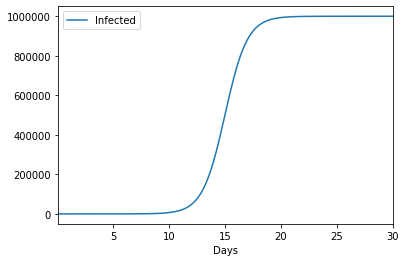

In [7]:
def P(t):
    return 1000000 / (1 + exp(-1 *(t - 15)))
X = np.arange(1, 301) / 10
Y = map(P, X)

df = pd.DataFrame({"Days" : X, "Infected" : Y})
df.plot(x = "Days", y = "Infected")
plt.show()

<a id="gaussnewton"></a>

#### Gauss-Newton Method for Least Squares Curve Fitting (LSCF)

To make use of the logistic equation, we will have to fit the paramters $A, \mu$, and $\sigma$ to our given data. To do that, we want to minimize the total sum of squared residuals (the same idea from linear regression in statistics). In other words, we want to find the paremters $\theta = <A, \mu, \sigma>$ that would minimize the following function:

$$F(\theta) = \sum_{i=1}^{n} (y_i - P_\theta(t_i))^2$$

where $y$ is our data point and $P_\theta(t)$ is the logistic function from earlier using the paramters $\theta = <A, \mu, \sigma>$.

Finding $\theta$ that would minimize this function is the same problem as finding the roots of a function's first derivative in the n-dimensional case. We can get an approximation of $\theta$ through multiple iterations of the Gauss-Newton Method shown below:

$$ \theta_{k+1} = \theta_k - H_f^{-1}(\theta_k)\nabla F(\theta_k) $$

where $\nabla F(\theta)$ and $H_f(\theta)$ are the gradient and Hessian of $F$ respectively.

Since computing for the inverse of a matrix is computationally expensive, we can instead use Gaussian Elimination. Thus, we can rewrite the term $ H_f^{-1}(\theta_k)\nabla F(\theta_k) $ as $ \text{GE}(H_f(\theta_k),\nabla F(\theta_k))$ giving us:

$$ \theta_{k+1} = \theta_k - \text{GE}(\ H_f(\theta_k),\nabla F(\theta_k)\ ) $$

Where $\text{GE}(A,b)$ is the Gaussian Elimination method with input matrices $A$ and $b$.


To facilitate solving the problem in that context, let's define the Residual Matrix as follows:

$$R(\theta) = \begin{bmatrix} y_1 - P_\theta(t_1) \\ y_2 - P_\theta(t_2) \\ \vdots \\ y_n - P_\theta(t_n) \end{bmatrix}$$

And redefine our objective function $F$ as:

$$ F(\theta) = \frac{1}{2}R^T(\theta)R(\theta) $$

From here, we can derive the following:

$$ 
\begin{array}{ c }
\nabla F(\theta) \approx J_R^T(\theta)R(\theta) \\
H_F(\theta) = J_R^T(\theta)J_R(\theta) 
\end{array}
$$

where $J_R(\theta)$ is the Jacobian of $R$ given by the following:

$$ 
\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{ c c c }
    J_R(\theta) & = & \Large \begin{bmatrix} \frac{\delta R_i}{\delta \theta_j} \end{bmatrix} \\
    & = & \Large \begin{bmatrix} \frac{\delta R_i}{\delta A} & \frac{\delta R_i}{\delta \mu} & \frac{\delta R_i}{\delta \sigma} \end{bmatrix} \\
    & = & \Large \begin{bmatrix} -\frac{1}{1 + \text{exp}(-\frac{t_i-\mu}{\sigma})} & \frac{A \ \text{exp}(-\frac{t_i-\mu}{\sigma})}{\sigma(1 + \text{exp}(-\frac{t_i-\mu}{\sigma}))^2} & \frac{A \ (t_i-\mu) \ \text{exp}(-\frac{t_i-\mu}{\sigma})}{\sigma^2(1 + \text{exp}(-\frac{t_i-\mu}{\sigma}))^2} \end{bmatrix}
\end{array}$$


We arrive at the following equation for the Gauss-Newton method:

$$ \theta_{k+1} = \theta_k - \text{GE}(\ J_R^T(\theta_k)J_R(\theta_k) \ , \ J_R^T(\theta_k)R(\theta_k) \ ) $$


The Least Square Curve Fitting (LSCF) method will iteratively improve an initial guess of our parameters $\theta_0$ using the equation for the Gauss-Newton method just described. 

Some important things to note:
- $\theta_0$ should be close enough to the eventual answer for the method to converge, otherwise it might diverge towards infinity
- might end up in a saddle point rather than the global minimum
- need to set a limit for the number of iterations beforehand 

With those in mind, below is code implementing LSCF (included is also some code implmenting Gradient/Steepest Descent which will be discussed in a later section): 

In [8]:
def LSCF(X, Y, A_0 = 100000, mu_0 = 40, sigma_0 = 1, iterations = 10, method = "Gauss-Newton"):
    ## Residual Matrix Constructor ###
    def R(theta):
        A, mu, sigma = theta[:,0]
        return matrix([ [y - ( A / ( 1 + np.exp( -(t-mu)/sigma ) ) )] for t, y in zip(X,Y)])
   
    ### Jacobian Matrix Constructor ###
    def J(theta):
        A, mu, sigma = theta[:, 0]
        return matrix([ 
                    [
                        - (1 / (1 + np.exp( -(t-mu)/sigma) ) ),
                        ( A * np.exp( -(t-mu)/sigma ) ) / ( sigma * ( 1 + np.exp( -(t-mu)/sigma ) )**2 ),
                        (A * (t - mu) * np.exp( -(t-mu)/sigma) ) / ( sigma * (1 + np.exp( -(t-mu)/sigma)) )**2
                    ] for t in X
                ])
    
    ### Objective Function ###
    def F(theta):
        R_k = R(theta)
        Rt_k = R_k.transpose()
        F_k = (0.5 * np.matmul(Rt_k, R_k))
        return F_k[0,0]
    
    def norm(A):
        A_t = A.transpose()
        ret = np.matmul(A_t, A)
        return ret[0,0]**(1/2)

    #### Theta ####
    # [A, mu, sigma]
    theta_k = matrix([[A_0],
                     [mu_0],
                     [sigma_0]])

    print("Least Squares Curve Fitting")
    
    ### Gauss-Newton Method (Non-linear Case) ###    
    if method == "Gauss-Newton":
        for i in range(iterations):
            J_k = J(theta_k)
            Jt_k = J_k.transpose()
            R_k = R(theta_k)
            gradient = np.matmul(Jt_k, R_k)
            hessian = np.matmul(Jt_k, J_k)

            theta_k = theta_k - GE(hessian, gradient)
            
    ### Gradient/Steepest Descent Method with Armijo's Line Search Condition ###
    if method == "Gradient Descent":
        for i in range(iterations):
            J_k = J(theta_k)
            Jt_k = J_k.transpose()
            R_k = R(theta_k)
            gradient = np.matmul(Jt_k, R_k)
            
            mu = 1.0
            theta_k1 = theta_k - mu * gradient
            
            ### Backtracking ###
            alpha = 0.1
            while F(theta_k1) >= F(theta_k) - 0.0001 * mu * norm(gradient):
                if mu == alpha * mu:
                    break
                mu *= alpha
                theta_k1 = theta_k - mu * gradient
                
            theta_k = theta_k1

    ### Fitted Logistic Function Arguments ###
    A, mu, sigma = theta_k[:, 0]
    print("A: {:.6f}, mu: {:.6f}, sigma: {:.6f}, F: {:.6f}".format(A, mu, sigma, F(theta_k)))
    
    return lambda t : (A / (1 + np.exp(-(t-mu)/sigma)))

Now we have all the tools we will need to start doing our analysis. Let us begin.

<a id="analysis"></a>

## 1. Analyzing the Covid19 Disease Transmission

First, we'll have to load and clean up our data a bit:

In [9]:
### Opening File ###
covid19_data = pd.read_csv(
    filepath_or_buffer = "covid_19_data.csv",
    index_col = ["SNo"],
    parse_dates = ["ObservationDate"],
    na_values = ["None"],
    skipinitialspace = True,
)

### Initial Cleanup ###
covid19_data.drop("Last Update", axis = 1, inplace = True)
covid19_data.fillna("", inplace = True)

### Swapping Columns ###
cols = covid19_data.columns.to_list()
i, j = [cols.index(x) for x in ["Country/Region", "Province/State"]]
cols[i], cols[j] = cols[j], cols[i]
covid19_data = covid19_data[cols]

### Removing Leading and Trailing Whitespace ###
str_cols = covid19_data.select_dtypes(include = ["object"])
covid19_data[str_cols.columns] = str_cols.apply(lambda x : x.str.strip())

### Sorting the Values ###
covid19_data.sort_values(by = ["Country/Region", "Province/State", "ObservationDate"], inplace = True)

### Filter Entries with Confirmed Cases ###
filt = covid19_data["Confirmed"] > 0
covid19_data = covid19_data[filt]

### Finding First Case per Area ###
per_area = covid19_data.groupby(by = ["Country/Region", "Province/State"]).first()
date_infection = per_area["ObservationDate"].to_dict()

### Adding First Date as Column ###
covid19_data.insert(1, "InfectionDate", [date_infection.get(x, pd.NaT) 
                                         for x in 
                                             zip(covid19_data["Country/Region"], covid19_data["Province/State"])
                                        ]
                   )

### Getting Number of Days Since First Infection ###
covid19_data["DaysSinceFirstCase"] = covid19_data["ObservationDate"] - covid19_data["InfectionDate"]
covid19_data["DaysSinceFirstCase"] = covid19_data["DaysSinceFirstCase"].dt.days

### Renaming Confirmed Column to Infections ###
covid19_data.rename(columns = {"Confirmed" : "Infections"}, inplace = True)

### Dropping Columns ###
covid19_data.drop(columns = ["InfectionDate"], inplace = True)
covid19_data

,ObservationDate,Country/Region,Province/State,Infections,Deaths,Recovered,DaysSinceFirstCase
SNo,,,,,,,
2259,2020-02-24,Afghanistan,,1,0,0,0
2352,2020-02-25,Afghanistan,,1,0,0,1
2453,2020-02-26,Afghanistan,,1,0,0,2
2557,2020-02-27,Afghanistan,,1,0,0,3
2665,2020-02-28,Afghanistan,,1,0,0,4
...,...,...,...,...,...,...,...
5989,2020-03-16,Vietnam,,61,0,16,53
6273,2020-03-17,Vietnam,,66,0,16,54
6556,2020-03-18,Vietnam,,75,0,16,55


To help shorten the code to create the necessary plots, I created the following utility function which should handle most of the use cases for our exploration of the data: 

In [10]:
def generate_graph(
    province = "", 
    country = "", 
    theta_0 = {"A_0" : 100000, "mu_0" : 40, "sigma_0" : 1},
    method = "Gauss-Newton",
    iterations = 10,
    extra = [], 
    scatter_color = "red",
    line_color = "blue",
    ax = None,
    x_col = "DaysSinceFirstCase",
    y_col = "Infections"
):
    ### Filter data to include only the specified Province/State and Country/Region ###
    filt = (covid19_data["Province/State"].str.contains(province)) & (covid19_data["Country/Region"].str.contains(country))
    data= covid19_data[filt]
    X = data[x_col].to_list() 
    Y = data[y_col].to_list()
    
    ### Append any extra data points ###
    for i,x in enumerate(extra):
        if i == 0:
            extra[i] = Y[-1] + x
        else:
            extra[i] = x + extra[i-1]
        
    X += list(range(len(X), len(X) + len(extra)))
    Y += extra
    
    ### Use Least Squares Curve Fitting to obtain the fitted logistic equation
    P = LSCF(X, Y, **theta_0, method = method, iterations = iterations)
    
    ### Create a pandas dataframe with the predicted values ###
    days = 101
    model = pd.DataFrame({
        "DaysSinceFirstCase" : range(days),
        y_col : Y + [np.nan for i in range(days - len(Y))],
        f"Predicted{y_col}": list(map(P, range(days)))
    })
    
    ### Plot the graph given the specified options ###
    if ax == None:
        ax = model.plot(kind = "scatter", x = x_col, y = y_col, color = scatter_color, figsize=(13,6))
        model.plot(x = x_col, y = f"Predicted{y_col}", color = line_color, ax = ax)
        
    else:
        model.plot(kind = "scatter", x = x_col, y = y_col, color = scatter_color, ax = ax, figsize=(13,6))
        
    model.plot(x = x_col, y = f"Predicted{y_col}", color = line_color, ax = ax)
    
    ### Label the Graph Axes ###
    ax.set_xlabel("Time from First Infection (Days)")
    ax.set_ylabel(f"Number of {y_col}")
    if province == "":
        ax.set_title(f"Number of {y_col} in {country} over Time")
    elif country == "":
        ax.set_title(f"Number of {y_col} in {province} province over Time")
    else:
        ax.set_title(f"Number of {y_col} in {province}, {country} over Time")
    ax.get_legend().remove()
    plt.xticks(np.arange(0,101,10))
    
    return ax

<a id="china"></a>

### 1.1 A Look at China

To start off, it would be a good idea to take a look at where it all started. In particular, the disease was first discovered in Wuhan, the capital city of the Hubei province of China. 

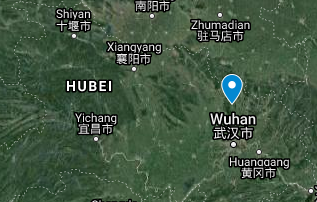

From there, it began to spread to neighboring areas and even overseas as people evacuated. For now, let's restrict our focus to Hubei and some nearby provinces. In particular, we'll be looking at Henan, Hubei, Hunan, and Guangdong

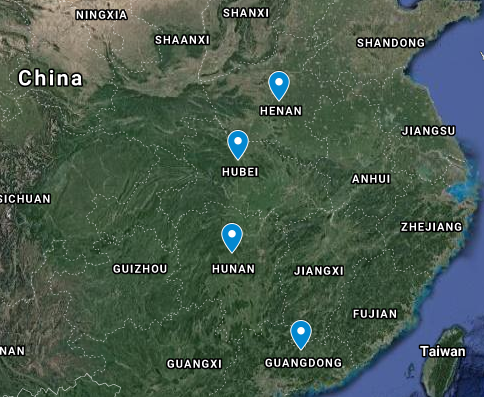

Least Squares Curve Fitting
A: 67709.533611, mu: 18.688297, sigma: 4.256317, F: 118193247.926538
Least Squares Curve Fitting
A: 1347.143676, mu: 11.731428, sigma: 3.581716, F: 8391.111061
Least Squares Curve Fitting
A: 1271.106635, mu: 12.688221, sigma: 3.536707, F: 5726.586003
Least Squares Curve Fitting
A: 1017.680632, mu: 11.904742, sigma: 3.501637, F: 5200.492748


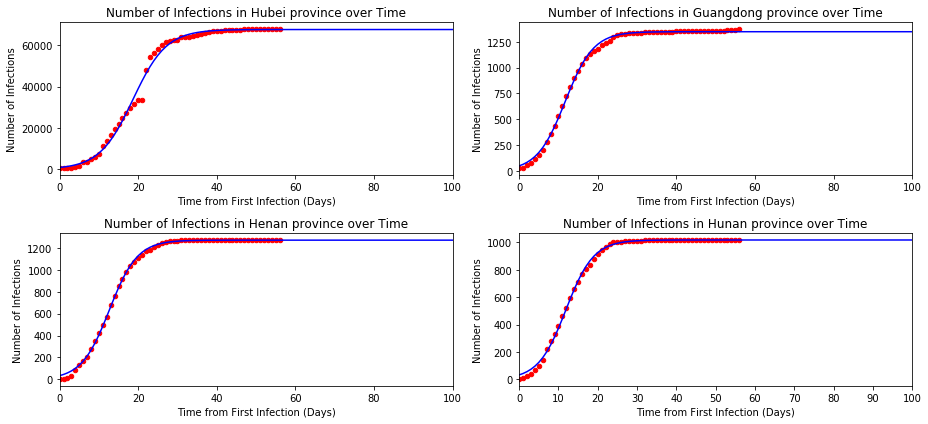

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
theta = {
    "A_0" : 100000, 
    "mu_0" : 20,
    "sigma_0" : 1,
}

generate_graph(province = "Hubei", theta_0 = theta, ax = axes[0,0])
generate_graph(province = "Guangdong", theta_0 = theta, ax = axes[0,1])
generate_graph(province = "Henan", theta_0 = theta, ax = axes[1,0])
generate_graph(province = "Hunan", theta_0 = theta, ax = axes[1,1])
fig.tight_layout()

A quick look at the predicted curves for these four provinces gives the idea that the actual number of infections in these areas closely follows a logistic curve. Following that idea, it appears as though the number of infections have likely reached their respective carrying capacities.

Another interesting thing to note would be that the four provinces managed to reach carrying capacity in roughly the same amount of time, with Hubei taking a few days longer than the rest. We can get a sense of this by taking a look at the parameter $\mu$. 

As mentioned earlier, $\mu$ would give us the number of days for half the carrying capacity to get infected. The $\mu$ for parameter for Hubei, Guangdong, Henan, and Hunan come out to be around $18$, $11$, $12$, and $12$ days respectively. 

Notice how Hubei's infections take longer to reach half the carrying capacity compared to the other three. It is important to note that this does not indicate that the spread of the virus is slower in Hubei, and this becomes clear when also paying attention to the predicted carrying capacity in these areas (indicated by the parameter $A$) with approximately $67000$ total infections in Hubei compared to the approximately $1000$ infections in the other three provinces. In fact, Hubei's higher carrying capacity and longer half time make sense with the knowledge that the epicenter of the virus was in Hubei.

However, all these observations are in hidsight. The trend was practically confirmed just by looking at the graph of the raw data. How would fitting a curve to premature data turn out?

<a id="italy"></a>

### 1.2 Forecasting in Italy

For our next destination, let's explore the data from Italy. 

First of all, let's take a look at where Italy stands in the world covid rankings:

In [12]:
world_data = covid19_data.groupby(by=["Country/Region","Province/State"]).last()
world_data = world_data.groupby(by = ["Country/Region"]).sum()
world_data = world_data.sort_values(by=["Infections","Deaths"], ascending = False)
world_data.head(10)

,Infections,Deaths,Recovered,DaysSinceFirstCase
Country/Region,,,,
Mainland China,80906,3237,69653,1718
Italy,35713,2978,4025,47
Iran,17361,1135,5389,28
Spain,13910,623,1081,46
Germany,12332,28,105,49
France,10864,181,24,77
US,8479,141,120,1272
South Korea,8413,84,1540,56
UK,3480,86,103,61


Currently, Italy sits as the country with the **2nd** most number of infections and deaths, right below Mainland China. However, despite the number of infections being far below China's, with Italy having $35713$ total infections and China having $80906$ total infections, the number of *deaths* in Italy is alarmingly close to China's, with Italy having $2978$ deaths and China having $3237$ deaths overall. 

To further make sense of this, let's try plotting the number of infections along with its fitted logistic curve:

Least Squares Curve Fitting
A: 74036.402344, mu: 47.299330, sigma: 4.530081, F: 3669927.931074


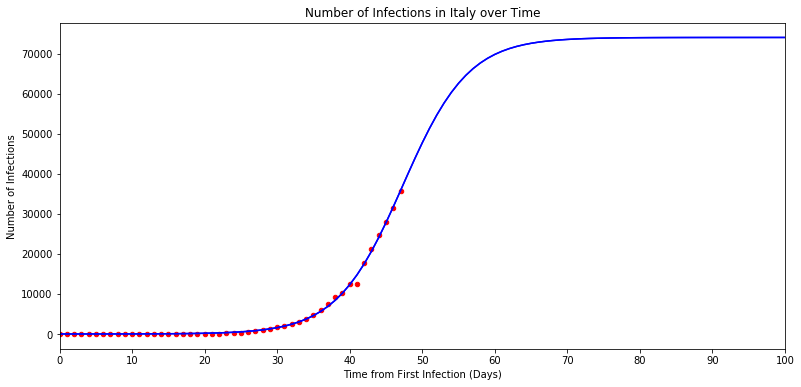

In [13]:
generate_graph(country = "Italy")

It seems as though the number of infections seem to fit the opening tail of our logistic curve. Given that the data still appears to be incomplete, it might be interesting to try and forecast the number of infections based on our fitted curve.
According to our fitted parameters, we would predict that Italy would have approximately $74000$ total infections, capping off after about $90$ days from the first infection. 

However, unlike the plots we created for the Chinese provinces, the number of infections have yet to fully trace a logistic curve. Because of this, it would be premature to use these points alone as a basis for a forecast. The trajectory of our curve can drastically change depending on the next day's number of infections.

To illustrate this, let's assume that the next-day number of infections are either **(a)** $1000$ new cases or **(b)** $10000$ new cases.
We can quickly see how premature forecasting could lead to inaccurate predictions.

Least Squares Curve Fitting
A: 59255.530708, mu: 45.563908, sigma: 4.222605, F: 5574088.206127
Least Squares Curve Fitting
A: 164169.346697, mu: 53.247981, sigma: 5.205147, F: 9288627.445409
Least Squares Curve Fitting
A: 74036.402344, mu: 47.299330, sigma: 4.530081, F: 3669927.931074


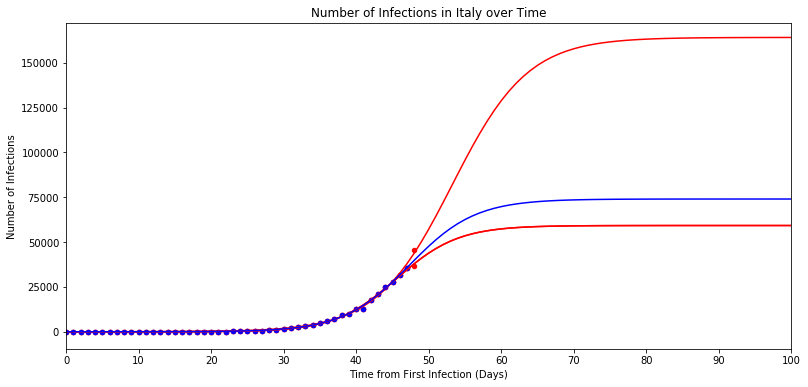

In [14]:
ax = generate_graph(country = "Italy", extra = [1000], line_color = "red", scatter_color = "red")
generate_graph(country = "Italy", extra = [10000], line_color = "red", scatter_color = "red", ax = ax)
generate_graph(country = "Italy", scatter_color = "blue", ax = ax)

As can be seen from the graph above, the predictions for our carrying capacity, the overall total infections, veered away from our original predictions. We have **(a)** $1000$ new infections the next day leading to a total of around $60000$ infections and with **(b)** $10000$ leading to a predicted total of around $160000$ infections. As can be seen, it is possible for our predictions to be either higher or lower depending on the new data for the next day alone. Premature forecasting is a tricky business.

<a id="philippines"></a>

### 1.3 Forecasting in the Philippines

Now that we've covered some ground, let's look at the data here in the Philippines and attempt to make a responsible forecast on the number of infections.

Least Squares Curve Fitting
A: 264.576233, mu: 45.118552, sigma: 2.421908, F: 493.745355


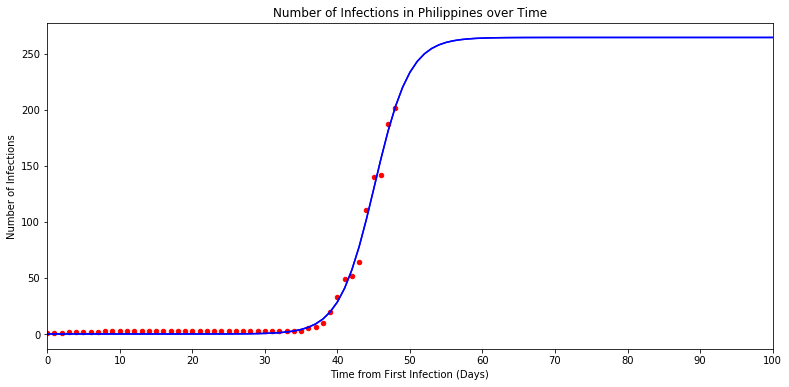

In [15]:
generate_graph(country = "Philippines")

Similar to the graph we got from Italy, the number of infections in the Philippines seem to follow the opening tail of a logistic curve. However, as mentioned before when we looked at Italy, if we attempt to make a forecast using only the existing data without any other strategies, then we might end up with a wildly inaccurate forecast. How might we remedy this?

<a id="assumptions"></a>

#### Making Assumptions

Similar to what we did in Italy, one idea might be to test different assumptions for how the virus might spread in the next few days, and creating a range of possible values rather than predicting for a single value. Let's test that out. 

First, let's take a look at some of the recent numbers to gain ideas on what assumptions we could test:

In [16]:
covid19_data[covid19_data["Country/Region"] == "Philippines"].tail(10)

,ObservationDate,Country/Region,Province/State,Infections,Deaths,Recovered,DaysSinceFirstCase
SNo,,,,,,,
4326,2020-03-09,Philippines,,20,1,1,39
4586,2020-03-10,Philippines,,33,1,2,40
4790,2020-03-11,Philippines,,49,1,2,41
5007,2020-03-12,Philippines,,52,2,2,42
5198,2020-03-13,Philippines,,64,5,2,43
5446,2020-03-14,Philippines,,111,8,2,44
5686,2020-03-15,Philippines,,140,11,2,45
5957,2020-03-16,Philippines,,142,12,2,46
6223,2020-03-17,Philippines,,187,12,5,47


From the looks of it, the number of new infections per day seem to be gradually increasing over time. However, it's also worth noting that this gradual increase does not seem to be consistent, with some days having far fewer new infections compared to previous days. For example, from $43$ to $44$ days since the first infection, there was a jump from $64$ to $111$ infections, indicating $47$ new infections. However, from $45$ to $46$ days since the first infection, there were only $2$ new reported infections. This might be an indiciation of other factors that affect the spread of the virus *or* issues with the reporting of data; it is hard to tell from these numbers alone.

With these ideas in mind, let's try to come up with a few assumptions for the next $20$ days:
1. That the number of new infections slightly increase.
2. That the number of new infections increase on average with some days having less than the average.
3. That the number of new infections drastically increase.
4. That the number of new infections drastically increase on average with some days having less than average.

Least Squares Curve Fitting
A: 4577.508542, mu: 65.090784, sigma: 5.721524, F: 7878.711137
Least Squares Curve Fitting
A: 5565.000703, mu: 74.481891, sigma: 7.834706, F: 20662.456365
Least Squares Curve Fitting
A: 10034.675984, mu: 64.945849, sigma: 4.712334, F: 48353.808973
Least Squares Curve Fitting
A: 9967.054532, mu: 71.931344, sigma: 6.046986, F: 64231.084572
Least Squares Curve Fitting
A: 264.576233, mu: 45.118552, sigma: 2.421908, F: 493.745355


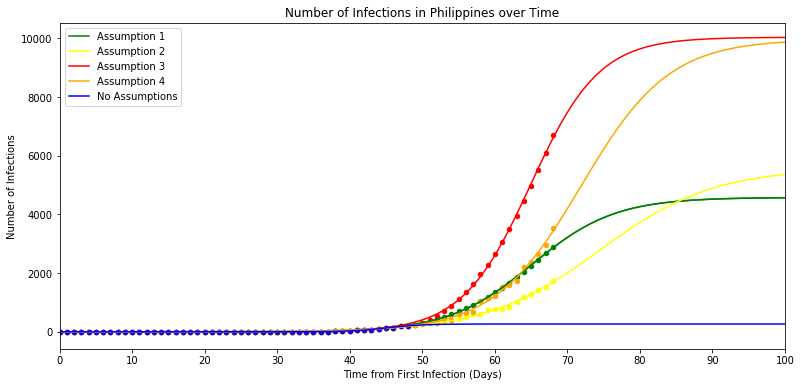

In [17]:
theta = {
    "A_0" : 100000, 
    "mu_0": 60,
    "sigma_0" : 1,
}
assumption1 = [40, 50, 60,   70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]
assumption2 = [40, 50,  2,    6,  60,  20,  40,  70, 100,   7, 130,  50,  10,  70, 150, 180,  90, 150, 100, 190]
assumption3 = [40, 70, 100, 130, 160, 190, 220, 250, 280, 310, 340, 370, 400, 430, 460, 490, 520, 550, 580, 610]
assumption4 = [40, 10,  37,   4, 100,  18, 180,  50,  30, 370, 100,  90, 290,  80, 120, 500, 140, 300, 290, 580]
ax = generate_graph(country = "Philippines", extra = assumption1, theta_0 = theta, line_color = "green", scatter_color = "green")
generate_graph(country = "Philippines", extra = assumption2, theta_0 = theta, line_color = "yellow", scatter_color = "yellow", ax = ax)
generate_graph(country = "Philippines", extra = assumption3, theta_0 = theta, line_color = "red", scatter_color = "red", ax = ax)
generate_graph(country = "Philippines", extra = assumption4, theta_0 = theta, line_color = "orange", scatter_color = "orange", ax = ax)
generate_graph(country = "Philippines", scatter_color = "blue", ax = ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ["Assumption 1", "Assumption 2", "Assumption 3", "Assumption 4", "No Assumptions"])

As we can see from the resulting curves, our assumptions on what might happen over the next $20$ days had a significant impact on the values we might obtain from attempting to forecast the number of infections. The original curve (in blue) now appears to be an inaccurate prediction. Now, we might be able to forecast the total number of infections in the Philippines to be within the range of around $4500$ up to around $10000$ depending on what assumptions hold true.

One thing that I would like to point out is that the values used in my assumptions were arbitrarily chosen based on my own sense of what it meant for those assumptions to hold true. I could have just as easily chosen smaller or larger values to illustrate this strategy, and doing so would have also led to different values for our predictions. I'm sure there are sounder ways of utilizing this technique, but those are outside the scope of my knowledge at the moment.

With that said, this strategy of utilizing some assumptions is still a useful one. Given the right assumptions, it has the possibility of giving some degree of confidence in a range of possible values that might capture the eventual number of infections. This is definitely better than having only one prediction that may be highly inaccurate.

<a id="pitfalls"></a>
### 1.4 Other Pitfalls

Before concluding, I would just like to explore other pitfalls and misconceptions that might arise from attempting to analyze the data and forecast some values. 

<a id="determinism"></a>

#### Determinism 

To illustrate my first point, let's take a look at the infection graph of South Korea:

Least Squares Curve Fitting
A: 8213.511064, mu: 39.683215, sigma: 2.981547, F: 177564.674433


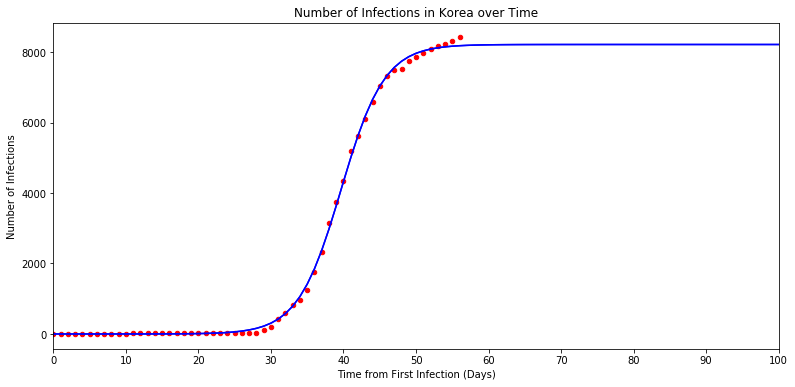

In [18]:
generate_graph(country = "Korea")

At an initial glance, South Korea's numbers seem to be following a logistic curve except for the numbers from the last three days which appear to be going above the projected carrying capacity.

For now, let's pay attention to the spike in numbers starting at around $27$ days since the first infection. Let's take a look at what date that falls under: 

In [19]:
filt = (covid19_data["Country/Region"] == "South Korea") & (covid19_data["DaysSinceFirstCase"] == 27)
covid19_data[filt]

,ObservationDate,Country/Region,Province/State,Infections,Deaths,Recovered,DaysSinceFirstCase
SNo,,,,,,,
1750,2020-02-18,South Korea,,31,0,12,27


We find that the sudden spike in numbers begins at around **February 18, 2020**. These dates actually coincide with the beginning of South Korea's intensive mass-testing and risk reduction after the discovery of Patient 31, a citizen who was believed to have spread the virus to hundreds of people in the city of Daegu. ([Source](https://www.institutmontaigne.org/en/blog/fighting-coronavirus-pandemic-east-asian-responses-republic-korea-mass-testing-targeted))

The point I want to make here is that the trajectory of how the virus might spread can be heavily influenced by what people do along with the actions governments take to monitor and mitigate it. The trend might have been completely different if Patient 31 had been more careful or if the government responded too late.

Another thing to keep in mind is that the reported numbers might not actually reflect the actual spread of the virus, but rather, it could be a reflection of a country's data gathering process with regards to the virus. The spike in the numbers present in South Korea's graph may not mean that the virus actually spread to more people in that time. It might also mean that more people were tested compared to before, leading to higher numbers. There is an important distinction with these two interpretations, both having their own grounding. 

In other words, the data and the models are not deterministic. We aren't trying to find a magical curve that happens to be the exact fit for how the virus might spread in an area. In fact, the logistic curve is only one model out of many that we may employ to help make sense of the data. Rather, we are using these curves and other models as tools to help us understand trends that are already there. We can use these models to forecast how the trends might evolve, but there is no guarantee that any of those will be determinedly true. Instead, we can use these models and the insights we gain from them to take action and influence how things might turn out.



<a id="manipulation"></a>

#### Result Manipulation

Another pitfall, or might I say temptation, to fall for is to manipulate the results to further your own analysis or forecast. In particular, I'll explore a strategy that takes advantage of premature forecasting.

For the purposes of this section, I'll instead make use of the **Gradient Descent** method instead of the Gauss-Newton method which we have been using for most of this analysis. Similar to the Gauss-Newton method, Gradient Descent will attempt to iteratively find better solutions to our minimization problem by utiling the gradient in this manner:  

$$ \theta_{k+1} = \theta_{k} - u_k \nabla F(\theta_{k}) $$

where $\theta$ would be the vector of our fitted parameters, $u$ would be our step size, and $\nabla F(\theta_k)$ would be the gradient of our objective function. 

To find an appropriate step size $u$, we'll make use of **backtracking** with **Armijo's Line Search Condition**. 

We'll start with one full gradient step:
  
$$ u_k^0 = 1$$

if the step isn't steep enough, we'll keep making iteratively make it smaller by a factor of $\alpha$, $\alpha \in (0,1)$:

$$ u_k^{(i+1)} = \alpha \ u_k^{(i)} $$

The condition to know if it's steep enough will be the following:

$$ F(\theta_{k+1}) < F(\theta_k) - \beta \ u \ || \nabla F(\theta_k) || $$

where $\beta$ would be some constant (around $10^{-4}$). This condition will guarentee that the backtracking method will work faster than the descent algorithm. One thing to take note of however, is that Gradient Descent typically takes more iterations to converge compared to the Gauss-Newton method.

All of this was already implemented earlier under the LSCF method, so all we have to do is to call it. 

Now the question is, how will this allow us to manipulate the results?

You see, one of the problems with this implementation of gradient descent is that it tends to get stuck at local minima. This is something we can take advantage of in order to manipulate our results.

For example, let's go back to our original curve for Italy using the Guass-Newton method:

Least Squares Curve Fitting
A: 74036.402344, mu: 47.299330, sigma: 4.530081, F: 3669927.931074


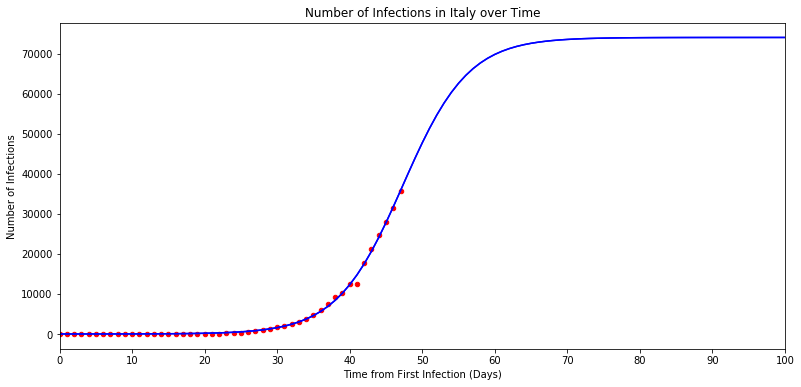

In [20]:
ax = generate_graph(country = "Italy")

Currently, the forecasted carrying capacity for this curve would be at around $74000$. If we were to modify our original guess for the parameters, and make use of Gradient descent, we could come up with a different curve. To illustrate that, I'll superimpose a few gradient descent generated curves onto the old one:

Least Squares Curve Fitting
A: 74036.402344, mu: 47.299330, sigma: 4.530081, F: 3669927.931074
Least Squares Curve Fitting
A: 80000.000189, mu: 47.934699, sigma: 4.647006, F: 3734132.679505
Least Squares Curve Fitting
A: 99999.999994, mu: 49.748339, sigma: 4.935637, F: 4377812.962517
Least Squares Curve Fitting
A: 119999.999905, mu: 51.201884, sigma: 5.123920, F: 5119407.884468


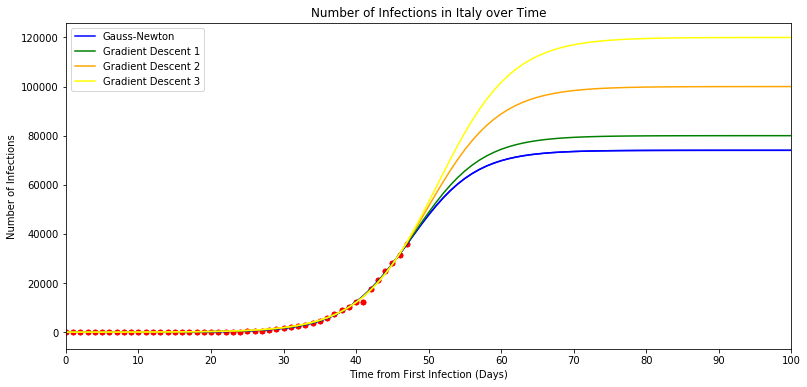

In [21]:
theta1 = {
    "A_0" : 80000,
    "mu_0" : 50,
    "sigma_0" : 4,
}
theta2 = {
    "A_0" : 100000,
    "mu_0" : 50,
    "sigma_0" : 4,
}
theta3 = {
    "A_0" : 120000,
    "mu_0" : 50,
    "sigma_0" : 4,
}
ax = generate_graph(country = "Italy")
generate_graph(country = "Italy", method = "Gradient Descent", theta_0 = theta1, iterations = 100, line_color = "green", ax = ax)
generate_graph(country = "Italy", method = "Gradient Descent", theta_0 = theta2, iterations = 100, line_color = "orange", ax = ax)
generate_graph(country = "Italy", method = "Gradient Descent", theta_0 = theta3, iterations = 100, line_color = "yellow", ax = ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ["Gauss-Newton", "Gradient Descent 1", "Gradient Descent 2", "Gradient Descent 3"])

As can be seen from the graph, the curves generated by my Gradient Descent method ended up with different curves compared to the one generated by the Gauss-Newton method. These other curves created by Gradient Descent actually stayed relatively close to the initial guesses for the parameters. This behavior could easily be taken advantage of in order to make the results adhere to a conclusion you would want to forward.

The only way to tell if these curves were actually created soundly would be to understand the methods used in generating them. If someone with enough background knowledge in the topic were to look at the values of the objective function $F$ generated by the Gradient Descent method, that person would be able to tell that the values aren't actually minimized, at least in comparison to the value of the one from the Gauss-Newton method.

Indeed, there are other ways of implementing Gradient Descent in order to avoid this problem. However, if these kinds of graphs were presented to someone without the background knowledge, that someone would take likely just take it at face value. Using a fancy term like "Gradient Descent" might be enough to convince someone without the expertise that the results from erroneous methods are to be believed.

Both in interpretting other people's analyses on the numbers and doing it on your own, it's important to understand the tools and techniques that are being utilized in order to make sure that what is there is valid and accurate.

<a id="conclusion"></a>

### Conclusion

To summarize:

- In section 1.1, we saw how easy it is to analyze and interpret curves generated from data that are nearly complete or have fully shown a logistic trend like the provinces in China


- In section 1.2, we learned that premature forecasting is susceptible to inaccurate predictions because of how easily the trend may change from future data like the data from Italy


- In section 1.3, we discussed a strategy to lower the inaccuracies of premature forecasting by trying to make assumptions on future trends and applying that to the Philippines's data


- In section 1.4, we discussed the misconception of determinism and the potential of result manipulation through the examples of South Korea and Italy's data

In conclusion, I would recommend that anyone attempting to analyze and interpret data in order to make informed decision or policies should understand the difficulties in attempting to forecast from incomplete data. Along with that, it is also necessary to understand the methods that were used to gain the insights drawn from the data, otherwise they might be susceptible to inaccurate or invalid results. It is important to listen to experts who have a greater understanding and mastery of the techniques and knowledge required to make sensible conclusions. Remember that the trends are not destiny, and that action can make things go for the better or for the worse. 

To end, I will leave you with this quote:


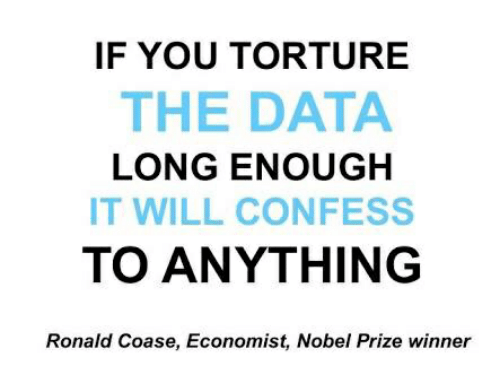

That's all. Thank you for reading!